# Transfer learning for NLP classification

**Use a pretrained language model (trained on *wiki103*) to finetune on movie reviews to then finally classify movie reviews.**

In [1]:
from fastai.text import *
import html

In [2]:
PATH = Path('data/aclImdb/')

In [3]:
SOS = 'xbos' # Start/beginning of sentence
FLD = 'xfld' # data field tag

## Standardize format

In [4]:
# Classification path: sentiment analysis
CLASS_PATH = Path('data/imdb_class/')
CLASS_PATH.mkdir(exist_ok=True)

# Language model path
LM_PATH = Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [5]:
CLASSES = ['neg', 'pos', 'unsup']

In [6]:
def get_texts(path):
    texts, labels = [], []
    for idx, label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

In [7]:
trn_texts, trn_labels = get_texts(PATH/'train')

In [8]:
val_texts, val_labels = get_texts(PATH/'test')

In [9]:
len(trn_texts), len(val_texts)

(75000, 25000)

### Shuffle the dataset ...

In [10]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [11]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

### ... and create pandas dataframes to store data as csv

In [12]:
column_names = ['labels', 'text']

In [13]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=column_names)

In [14]:
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=column_names)

#### csv files for classification
Remove all texts with label `unsup`.

In [15]:
df_trn[df_trn['labels']!=2].to_csv(CLASS_PATH/'train.csv', header=False, index=False)

In [16]:
df_val.to_csv(CLASS_PATH/'test.csv', header=False, index=False)

In [17]:
(CLASS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

In [18]:
df_trn.head()

,labels,text
0,2,In the first and most memorable scene in this ...
1,0,"Why is this film so bad? Well, if being so stu..."
2,1,Ruth Gordon is one of the more sympathetic kil...
3,2,I used to subscribe to Toyfare magazine and on...
4,2,...and I don't mean nuclear!! This movie is pr...


#### csv files for language model
Labels can be ignored, so also `unsup` labeled texts can be used.

In [19]:
trn_texts, val_texts = sklearn.model_selection.train_test_split(np.concatenate([trn_texts, val_texts]), test_size=0.1)

In [20]:
len(trn_texts), len(val_texts)

(90000, 10000)

In [21]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=column_names)

In [22]:
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=column_names)

In [23]:
df_trn.head()

,labels,text
0,0,"Hoo dawgies, what can I say about this movie t..."
1,0,"Back when cable TV started, there were tons of..."
2,0,"Viewing this film makes you question, no pun i..."
3,0,"no, this is not supposed to be a high budget b..."
4,0,"This is meant to be a thriller, but the audien..."


In [24]:
df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Tokenization
Cleanup of text:

1. Replace extra spaces, tab chars, new line chars and other chars with standard tokens
1. Use *spacy* to tokenize the data. Fastai adds multicore functionality to spacy.

*Chunksize:* `pd.read_csv` returns iterator so that we don't have to load the entire dataset into memory at once. 

In [25]:
chunksize = 24000

In [26]:
# Compile a regular expression pattern, returning a pattern object.
new_re = re.compile(r' +')

def cleanup(x):
    '''Many nlp datasets contain strange characters. This function removes them.'''
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return new_re.sub(' ', html.unescape(x))

In [27]:
# Start every training/testing example with SOS token so that language model can learn that a new text starts and it might need to forget its state. If there are several text columns, start each of them with {FLD} index so that the language model is able to distinguish between the columns.

def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{SOS} {FLD} 1 ' + df[n_lbls].astype(str)

    # here {FLD} 1 will be used twice if there is more than 1 text column i think. TODO: check this out
    for i in range(n_lbls+1, len(df.columns)):
        texts += f' {FLD} {i-nlbls} ' + df[i].astype(str)
        
    # cleanup disturbing chars
    texts = list(texts.apply(cleanup).values)
    
    # tokenize using multicore functionality
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    
    return tok, list(labels)

In [28]:
def get_all(df, n_lbls):
    tok, labels = [], []
    # remeber that df is split into pieces of size chunksize
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
        
    return tok, labels

In [29]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)

df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

**Attention:**
If at this point of the notebook you do sth like this, you lose the first chunksize samples: 
`next(iter(df_trn)).head()`
Don't do that!

In [30]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [31]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

#### Save tokens

In [32]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [33]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [34]:
# Counter counts hashable items
frequency = Counter(tok for i in tok_trn for tok in i)

In [35]:
frequency.most_common(25)

[('the', 1208409),
 ('.', 991990),
 (',', 985348),
 ('and', 588114),
 ('a', 583960),
 ('of', 525638),
 ('to', 485093),
 ('is', 393943),
 ('it', 341786),
 ('in', 337659),
 ('i', 307547),
 ('this', 270652),
 ('that', 261453),
 ('"', 236846),
 ("'s", 221476),
 ('-', 188208),
 ('was', 180289),
 ('\n\n', 178920),
 ('as', 165777),
 ('with', 159249),
 ('for', 158941),
 ('movie', 157440),
 ('but', 150728),
 ('film', 144225),
 ('you', 124078)]

**Discard every token that appears less than 2 times. Vocabulary sizes <= 60,000 have been observed to yield good results.**

In [36]:
max_vocabs = 60000
min_freq = 2

In [37]:
itos = [tok for tok, count in frequency.most_common(max_vocabs) if count > min_freq]

In [38]:
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

**Reverse mapping from string to index:**

In [39]:
stoi = collections.defaultdict(lambda:0, {val:key for key, val in enumerate(itos)})

In [40]:
len(itos)

60002

In [41]:
trn_lm = np.array([[stoi[string] for string in text] for text in tok_trn])
val_lm = np.array([[stoi[string] for string in text] for text in tok_val])

In [42]:
' '.join([itos[o] for o in trn_lm[0][:20]])

'\n xbos xfld 1 hoo _unk_ , what can i say about this movie that has been said before and'

**Save:**

In [43]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)

pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [44]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [45]:
voc_size = len(itos)
print("Vocab size: {}, Number of training documents: {}".format(voc_size, len(trn_lm)))

Vocab size: 60002, Number of training documents: 90000


## Transfer learning for language models
### Download weights for AWD LSTM pretrained on *wiki103*

In [46]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [47]:
emb_sz, nhidden, nlayers = 400, 1150, 3   # parameters of pretrained network

In [48]:
PRE_PATH = PATH/'models'/'wt103'

In [49]:
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [50]:
weights = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [51]:
encoder_weights = to_np(weights['0.encoder.weight'])

**We will use the mean embedding to initialize the embedding for unkown tokens when we transfer the wikitext LM to the IMDB LM.**

In [52]:
mean_emb = encoder_weights.mean(0)

In [53]:
itos_wiki = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))

In [54]:
stoi_wiki = collections.defaultdict(lambda: -1, {value:key for key, value in enumerate(itos_wiki)})

### Map the IMDB vocab and the wikitext vocab

In [55]:
encoder_weights.shape

(238462, 400)

In [56]:
new_encoder_weights = np.zeros((voc_size, emb_sz), dtype=np.float32)
for imdb_idx, word in enumerate(itos):  # this is the IMDB vocab itos
    wiki_idx = stoi_wiki[word]          # word from imdb to idx in wiki
    new_encoder_weights[imdb_idx] = encoder_weights[wiki_idx] if wiki_idx >= 0 else mean_emb

In [57]:
new_encoder_weights.shape  # vocab_size, emb_size

(60002, 400)

### Overwrite the weights in the weights dictionary
The decoder module is loaded with the same weights due to *weight tying.*

In [58]:
weights['0.encoder.weight'] = T(new_encoder_weights)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_encoder_weights))
weights['1.decoder.weight'] = T(np.copy(new_encoder_weights))

## Create and train the IMDB language pytorch model
Goal is to learn to predict the next word given a sequence of preceeding words

In [59]:
wd = 1e-7
bptt = 70    
bs = 52

**bptt:**

`bptt` = "ngrams", in fastai perturbed around a mean of 70. The idea is that if you train for several epochs, the batches would always be the same if `bptt` would be constant. If `bptt` is varied, the batches differ every epoch and there is randomness that one might compare to image augmentation in cv.

In [60]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [61]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

In [62]:
# The 1 is '_pad_' token
modeldata = LanguageModelData(PATH, 1, voc_size, trn_dl, val_dl, bs=bs, bptt=bptt)

In [63]:
print("{} documents containing a total of {} tokens.".format(len(trn_lm), len(np.concatenate(trn_lm))))

90000 documents containing a total of 25008684 tokens.


**Dropout:**
These values have been determined through experimentation. You should only have to update the weighting factor (0.7).

1. For smaller datasets increase the weighting factor to reduce overfitting
1. For larger datasets you might be able to decrease it

In [64]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

### First step: finetune the embeddings (last layer)
Some tokens are missing in the pretrained wiki model. These should be learned in this step.

```
dropouth (float): dropout to apply to the activations going from one LSTM layer to another                                  
dropouti (float): dropout to apply to the input layer.                                                                      
dropoute (float): dropout to apply to the embedding layer.                                                                  
wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.                                   ```      

In [65]:
learner= modeldata.get_model(opt_fn=opt_fn, emb_sz=emb_sz, n_hid=nhidden, n_layers=nlayers, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]

In [66]:
learner.freeze_to(-1)  # freeze all but embedding layer

In [67]:
learner.model.load_state_dict(weights)
lr=1e-3
lrs = lr

In [69]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

  1%|          | 35/6869 [00:05<17:22,  6.56it/s, loss=5.25]
epoch      trn_loss   val_loss   accuracy                     
    0      4.677772   4.444184   0.257833  



[4.444183904042081, 0.25783323926797375]

In [72]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.631245   4.400647   0.261047  



[4.400647097685206, 0.26104733087806875]

In [73]:
learner.save('lm_finetuned_emb')

In [74]:
learner.load('lm_finetuned_emb')

### Second step: unfreeze the earlier layers

In [77]:
learner.unfreeze()

In [78]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.350103   4.155856   0.285788  
    1      4.24065    4.08416    0.29269                      
    2      4.155276   4.037142   0.297476                     
    3      4.110071   4.013286   0.300187                     
    4      4.095423   3.994488   0.30194                      
    5      4.051529   3.978413   0.303703                     
    6      4.065727   3.965502   0.304916                     
    7      4.016764   3.956877   0.306411                     
    8      3.981582   3.949974   0.307226                     
    9      3.994045   3.940068   0.308182                     
    10     4.012587   3.929011   0.309132                     
    11     3.975437   3.925294   0.309726                     
    12     3.932798   3.921386   0.310328                     
    13     3.898594   3.918957   0.310935                     
    14     3.906602   3.913427   0.31162                      



[3.913427404844229, 0.31161988681069824]

In [79]:
learner.save('lm_model_1')

In [80]:
learner.load('lm_model_1')

In [81]:
learner.save_encoder('lm_model_1_enc')

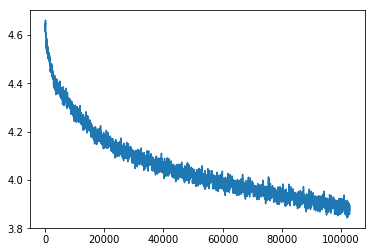

In [82]:
learner.sched.plot_loss()

## Set up data for classification
This time we cannot use the training examples labeld `unsup`.

In [201]:
df_trn = pd.read_csv(CLASS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLASS_PATH/'test.csv', header=None, chunksize=chunksize)

In [202]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [203]:
(CLASS_PATH/'tmp').mkdir(exist_ok=True)

**Save tokens and labels:**

In [204]:
np.save(CLASS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLASS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLASS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLASS_PATH/'tmp'/'val_labels.npy', val_labels)

In [205]:
tok_trn = np.load(CLASS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLASS_PATH/'tmp'/'tok_val.npy')

In [206]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))   # We obviously want to use the same numericalization

In [207]:
stoi = collections.defaultdict(lambda: 0, {string:idx for idx, string in enumerate(itos)})

In [208]:
len(itos)

60002

**Numericalize:**

In [209]:
trn_class = np.array([[stoi[string] for string in text] for text in tok_trn])
val_class = np.array([[stoi[string] for string in text] for text in tok_val])

**Save and load:**

In [210]:
np.save(CLASS_PATH/'tmp'/'trn_numericalized.npy', trn_class)
np.save(CLASS_PATH/'tmp'/'val_numericalized.npy', val_class)

In [211]:
trn_class = np.load(CLASS_PATH/'tmp'/'trn_numericalized.npy')
val_class = np.load(CLASS_PATH/'tmp'/'val_numericalized.npy')

In [212]:
trn_labels = np.squeeze(np.load(CLASS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLASS_PATH/'tmp'/'val_labels.npy'))

## Classification
### Add a custom linear head ontop of our language model

In [213]:
bptt = 70
emb_sz = 400
nhidden = 1150
nlayers = 3
bs = 48

In [214]:
voc_size = len(itos)

In [215]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [216]:
min_label = trn_labels.min()
trn_labels -= min_label
val_labels -= min_label

count = int(trn_labels.max()) + 1

In [217]:
count

2

**Since we intend to do classification, we have to read an entire movie review. Since the reviews don't have the same length, we have to pad the shorter ones in a batch.**

**To reduce padding and thus compute, we do the following things:**

1. For validation we sort the reviews regarding their lenghts, then we group them into batches. This reduces padding because there won't be *really long* and *really short* reviews in the same batch.
1. For training, we don't strictly sort, because we want more *randomness*. We use the *sortishSampler* which groups *larger* reviews together and *smaller* reviews together but maintains a degree of randomness while still reducing padding.

In [218]:
trn_ds = TextDataset(trn_class, trn_labels)  # trn_class[i] numericalized version of review i/tok_trn[i]
val_ds = TextDataset(val_class, val_labels)

In [219]:
trn_sampler = SortishSampler(trn_class, key=lambda x: len(trn_class[x]), bs=bs//2)
val_sampler = SortSampler(val_class, key=lambda x: len(val_class[x]))

In [220]:
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_sampler)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_sampler)

In [221]:
modeldata = ModelData(PATH, trn_dl, val_dl)

In [254]:
drops = np.array([0.4,0.5,0.05,0.3,0.4])#*0.5

In [223]:
model = get_rnn_classifier(bptt=bptt, max_seq=20*70, n_class=count, n_tok=voc_size, emb_sz=emb_sz, n_hid=nhidden, n_layers=nlayers, pad_token=1, layers=[emb_sz*3, 50, count], drops=[drops[4], 0.1], dropouti=drops[0], wdrop=drops[1], dropoute=drops[2], dropouth=drops[3])

In [224]:
learner = RNN_Learner(modeldata, TextModel(to_gpu(model)), opt_fn=opt_fn)

In [225]:
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)  # Regularization

In [226]:
learner.clip = 0.25  # Gradient clipping
learner.metrics = [accuracy]

In [227]:
import warnings

In [228]:
warnings.filterwarnings("ignore", category=UserWarning)

In [267]:
wd = 1e-7

In [261]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [230]:
learner.load_encoder('lm_model_1_enc')

### Step 1: Train only the last layer group

In [231]:
learner.freeze_to(-1)

In [232]:
learner.fit(lrs=lrs, n_cycle=1, wds=wd, cycle_len=1, use_clr=(8, 3))

  2%|▏         | 23/1042 [00:03<02:35,  6.56it/s, loss=0.497]
epoch      trn_loss   val_loss   accuracy                      
    0      0.266736   0.178909   0.93108   



[0.17890858514428137, 0.9310800185966491]

### Step 2: ... last two layer groups

In [233]:
learner.freeze_to(-2)

In [234]:
learner.fit(lrs=lrs, n_cycle=1, wds=wd, cycle_len=1, use_clr=(8, 3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.259551   0.161064   0.93888   



[0.161064199603796, 0.9388800192832947]

In [235]:
learner.save('classifier_before_unfreezing_all')

In [260]:
learner.load('classifier_before_unfreezing_all')

### Step 3: Unfreeze entire network

In [262]:
learner.unfreeze()

In [263]:
learner.fit(lrs=lrs, n_cycle=1, wds=wd, cycle_len=3, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.221449   0.170925   0.93912   
    1      0.176093   0.161105   0.9448                        
    2      0.149651   0.157458   0.94648                       



[0.15745827977597712, 0.9464800192451477]

In [264]:
learner.save('classifier_after_unfreezing')

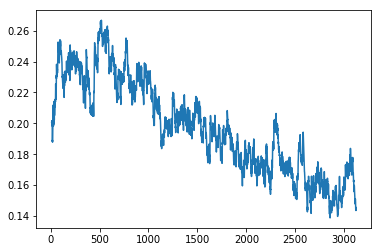

In [265]:
learner.sched.plot_loss()

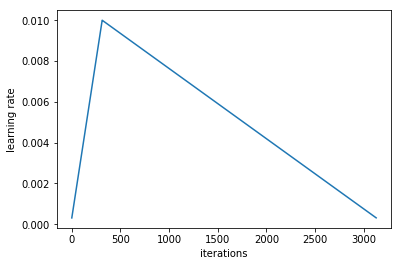

In [266]:
learner.sched.plot_lr()

**The previous state of the art for this dataset was 94.1%, by using Transfer learning for language models as developed by fastai we were able to beat this :)**

**TODO: Add a second language model that learns to classify reversed texts. Average the two predictions. This should give an even higher accuracy according to Jeremy!**